# Retina Image Classification with Deep Learning

Welcome to this end-to-end tutorial on **Retina Image Classification** using deep learning. In this notebook, you'll learn how to:

🔹 Preprocess and normalize retina images  
🔹 Handle unbalanced datasets  
🔹 Train and compare 8 different CNN models  
🔹 Use early stopping and monitor training with TensorBoard  
🔹 Evaluate results with confusion matrices and classification metrics  
🔹 Visualize where models “look” using Class Activation Maps (CAMs)

> ✅ Designed for **Google Colab** with GPU support  
> 📁 Input: TIFF retina images with a xml file indicating retinopathy grade from https://www.adcis.net/en/third-party/messidor/
> 🧠 Output: Trained models and interpretable performance insights


## 0. Dataset information

### **Description**

*   The 1200 eye fundus color numerical images of the posterior pole of the Messidor database were acquired by 3 ophthalmologic departments using a color video 3CCD camera mounted on a Topcon TRC NW6 non-mydriatic retinograph with a 45 degree field of view.
*   Images were captured using 8 bits per color plane at 1440*960, 2240*1488 or 2304*1536 pixels.
*   800 images were acquired with pupil dilation (one drop of Tropicamide at 0.5%) and 400 without dilation.
*   The 1200 images are packaged in 3 sets, one per ophthalmologic department.


### **Medical diagnoses**

Two diagnoses have been provided by the medical experts for each image:

1.   ***Retinopathy grade***

*   0 (Normal): (μA = 0) AND (H = 0)
*   1: (0 < μA <= 5) AND (H = 0)
*   2: ((5 < μA < 15) OR (0 < H < 5)) AND (NV = 0)
*   3: (μA >= 15) OR (H >=5) OR (NV = 1)

   *   μA: number of microaneurysms
   *   H: number of hemorrhages
   *   NV = 1: neovascularization
   *   NV = 0: no neovascularization



2.   ***Risk of macular edema***

*   0 (No risk): No visible hard exudate
*   1: Shortest distance between macula and hard exudates > one papilla diameter
*   2: Shortest distance between macula and hard exudates <= one papilla diameter
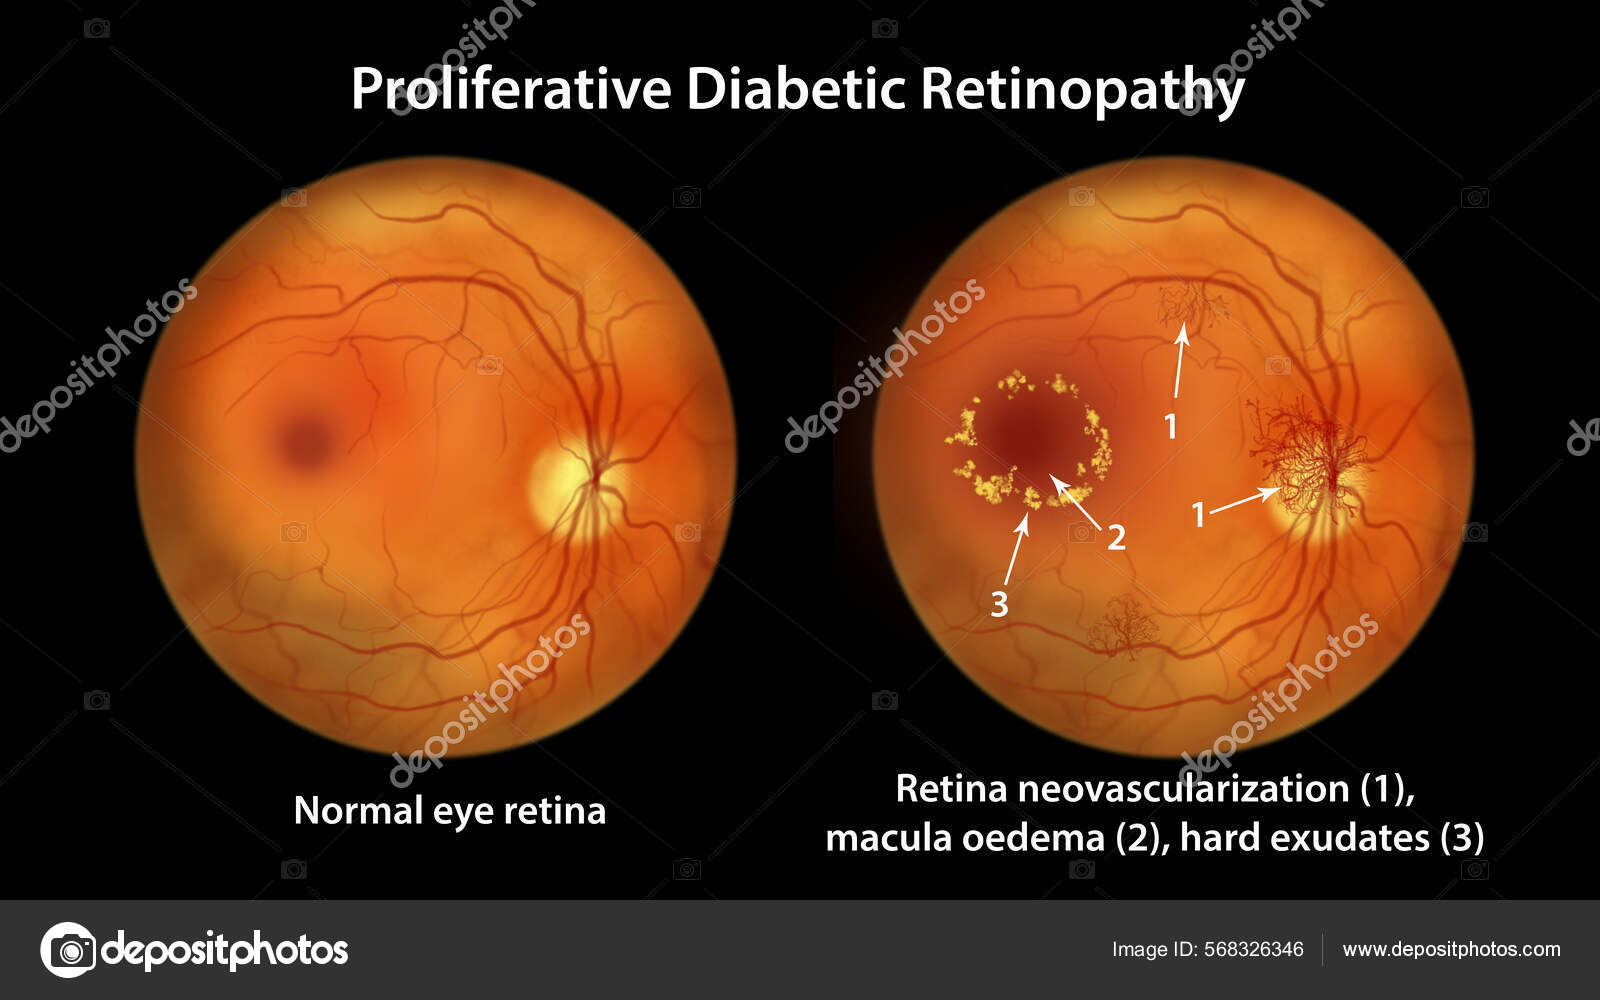

## 1. Initial Setup




###  Importing Modules & Packages




In [4]:
# Libraries for operating system and file handling
import os                         # Interacting with the file system (directories, paths)
import time                       # Time measurements (e.g., training duration)
import random                     # Random number generation (e.g., for reproducibility)
from datetime import datetime  # Imports the datetime class to work with dates and times (e.g., timestamps, formatting)
import gdown       # For downloading files from Google Drive using their shareable URL
import patoolib    # For extracting archive files (e.g., .rar, .zip, .tar) using external tools like unrar or 7z
import re

# Libraries for numerical and data analysis
import numpy as np                # NumPy for efficient numerical computations
import pandas as pd               # Pandas for handling tabular data (e.g., labels)
from math import log10            # Used for computing logarithmic values (if needed)


# Libraries for visualization and progress tracking
import matplotlib.pyplot as plt   # Matplotlib for plotting images and performance metrics
from tqdm import tqdm             # TQDM for progress bars in loops and data loading

# Libraries for image processing and manipulation
from PIL import Image, ImageOps   # Pillow: Image for loading images, ImageOps for basic image operations (e.g., grayscale, inversion, padding)
import cv2                        # OpenCV for image processing (e.g., resizing, transformations)

# Libraries for machine learning utilities
from sklearn.model_selection import train_test_split         # Splitting data into train/val/test sets
from sklearn.metrics import (                                # Evaluation metrics
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# PyTorch libraries for building and training models
import torch                      # Core PyTorch library
import torch.nn as nn             # Neural network layers
import torch.nn.functional as F   # Functional interface (e.g., activation functions)
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler    # Custom datasets and data loading
from torch.utils.tensorboard import SummaryWriter            # Logging training to TensorBoard
from torchsummary import summary  # Utility for printing detailed layer-by-layer model summaries (input/output shapes, parameters)


# Torchvision libraries for pretrained models and transforms
import torchvision                # High-level PyTorch library for computer vision
from torchvision import transforms, models                   # Image transformations and model zoo
from torchvision.models.feature_extraction import create_feature_extractor  # For feature extraction from models


In [5]:
# Check for GPU Availability and number of CPU workers
def check_device():
    """
    Checks if a CUDA-capable GPU is available, prints device info,
    and runs a small matrix multiplication test to confirm GPU functionality.
    Also prints the number of available CPU workers.
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("⚠️ No GPU found. Using CPU.")

    num_workers = os.cpu_count()
    print(f"🧠 Number of available CPU workers: {num_workers}")
    print(f"🖥️ Using device: {device}")

    # Simple test calculation
    try:
        a = torch.rand((1000, 1000), device=device)
        b = torch.rand((1000, 1000), device=device)
        c = torch.matmul(a, b)
        torch.cuda.synchronize() if device.type == 'cuda' else None
        print("✅ GPU test calculation completed successfully.")
    except Exception as e:
        print(f"❌ GPU test failed: {e}")

    return device

# Run the device check
device = check_device()



✅ GPU available: NVIDIA GeForce RTX 3070 Ti Laptop GPU
🧠 Number of available CPU workers: 16
🖥️ Using device: cuda
✅ GPU test calculation completed successfully.


### Reproducibility Setup

In [6]:
# Set seeds for reproducibility across torch, numpy, and random
def set_seed(seed=42):
    """
    Sets global seeds for reproducibility.
    Ensures consistent behavior across runs by fixing random number generators.
    """
    torch.manual_seed(seed)                        # Seed PyTorch
    np.random.seed(seed)                           # Seed NumPy
    random.seed(seed)                              # Seed Python's random
    torch.backends.cudnn.deterministic = True      # Ensure deterministic results on GPU (slower)
    torch.backends.cudnn.benchmark = False         # Disable cuDNN auto-tuner for consistency

# Create a configurable worker_init_fn for DataLoader workers

def worker_init_fn(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)                # Set NumPy seed per worker
    random.seed(worker_seed)                   # Set Python random seed per worker
    torch.manual_seed(worker_seed)             # Optional: set torch seed too
    
# Apply the global seed
seed = 42
set_seed(seed)


## 2. Importing data

### Mount Google drive (optional)

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

### Download data for the tutorial

In [8]:
# Google Drive file ID
file_id = "11c6R5fx7bjPURVq2ZplF6Ner6-oPScaf"
url = f"https://drive.google.com/uc?id={file_id}"
output_file = "retina_dataset.rar"

# Download while bypassing SSL certificate check
#gdown.download(url, output_file, quiet=False, verify=False)

# Extract .rar file
output_folder = "retina_dataset"
os.makedirs(output_folder, exist_ok=True)

#patoolib.extract_archive(output_file, outdir=output_folder)

### Load labels and visualize dataset

In [9]:
# Define paths to the image directory and annotation file
data_dir = "C:/Users/andre/Documents/Work/Projects/Tutorials/Retina_classification/retina_dataset/dataset/images/" #"/content/drive/MyDrive/Tutorials/Image_Classification/data/images/"
excel_path = "C:/Users/andre/Documents/Work/Projects/Tutorials/Retina_classification/retina_dataset/dataset/Annotations.xls" #"/content/drive/MyDrive/Tutorials/Image_Classification/data/Annotations.xls"
health_condition = "Risk of macular edema " #"Retinopathy grade"

In [10]:
# Load the Excel file
df = pd.read_excel(excel_path)

# Select only the necessary columns
df = df[["Image name", health_condition]]

# Rename columns for consistency
df.columns = ["image_name", "label"]

# Create full image paths
df["image_path"] = df["image_name"].apply(lambda x: os.path.join(data_dir, x))

# Generate sorted list of class labels (e.g., 0, 1, 2, 3)
unique_labels = sorted(df["label"].unique())

# Create class names like "Grade 0", "Grade 1", ...
class_names = [f"Grade {label}" for label in unique_labels]

# Display the  DataFrame
df

,image_name,label,image_path
0,20051019_38557_0100_PP.tif,1,C:/Users/andre/Documents/Work/Projects/Tutoria...
1,20051020_43808_0100_PP.tif,0,C:/Users/andre/Documents/Work/Projects/Tutoria...
2,20051020_43832_0100_PP.tif,0,C:/Users/andre/Documents/Work/Projects/Tutoria...
3,20051020_43882_0100_PP.tif,0,C:/Users/andre/Documents/Work/Projects/Tutoria...
4,20051020_43906_0100_PP.tif,2,C:/Users/andre/Documents/Work/Projects/Tutoria...
...,...,...,...
195,20051214_56944_0100_PP.tif,2,C:/Users/andre/Documents/Work/Projects/Tutoria...
196,20051214_56971_0100_PP.tif,1,C:/Users/andre/Documents/Work/Projects/Tutoria...
197,20051214_57125_0100_PP.tif,2,C:/Users/andre/Documents/Work/Projects/Tutoria...
198,20051214_57154_0100_PP.tif,2,C:/Users/andre/Documents/Work/Projects/Tutoria...


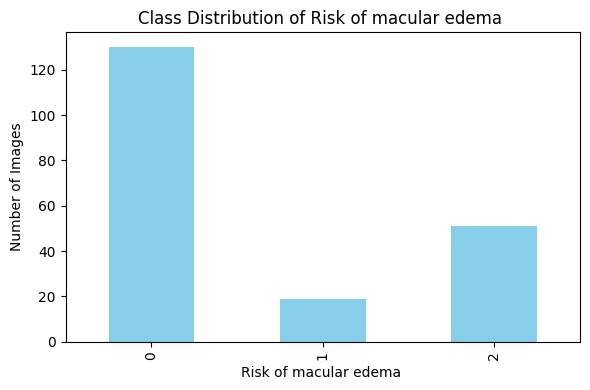

In [11]:
# Plot Class Distribution
plt.figure(figsize=(6, 4))
df['label'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Class Distribution of "+health_condition)
plt.xlabel(health_condition)
plt.ylabel("Number of Images")
plt.grid(False)
plt.tight_layout()
plt.show()


--- Images Metadata ---
Image: 20051021_39914_0100_PP.tif, grade:0 Risk of macular edema , shape: 560×372, # channels: C:3, Image depth:uint8
Image: 20051019_38557_0100_PP.tif, grade:1 Risk of macular edema , shape: 560×372, # channels: C:3, Image depth:uint8
Image: 20051214_52707_0100_PP.tif, grade:2 Risk of macular edema , shape: 560×372, # channels: C:3, Image depth:uint8
-----------------------


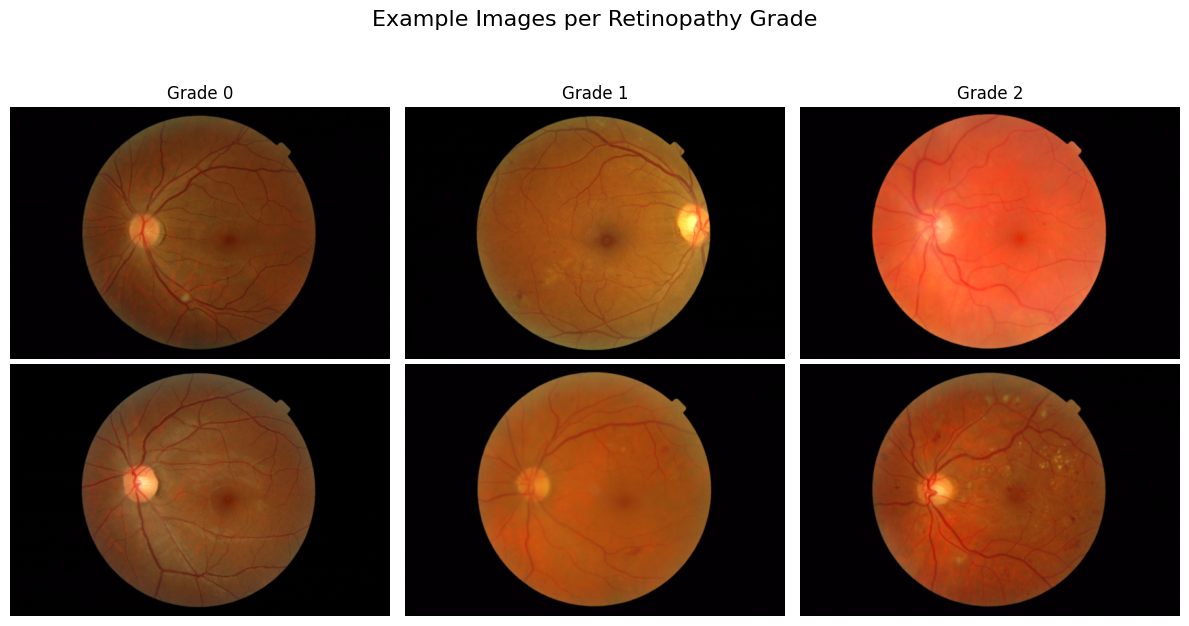

In [12]:
# Display Sample Images from Each Class

# Parameters
classes = sorted(df['label'].unique())
examples_per_class = 2
num_classes = len(classes)

# Set up the grid: rows = examples, columns = classes
fig, axes = plt.subplots(nrows=examples_per_class, ncols=num_classes, figsize=(num_classes * 4, examples_per_class * 3))
fig.suptitle("Example Images per Retinopathy Grade", fontsize=16, y=1.05)

print("--- Images Metadata ---")
# Plot examples_per_class random examples per class
for col, label in enumerate(classes):
    class_df = df[df['label'] == label]
    samples = class_df.sample(n=min(examples_per_class, len(class_df)), random_state=seed)

    for row in range(examples_per_class):
        ax = axes[row, col] if examples_per_class > 1 else axes[col]
        if row < len(samples):
            image_path = samples.iloc[row]['image_path']
            try:
                image = Image.open(image_path)
                img_array = np.array(image)

                # Extract image metadata
                width, height = image.size
                channels = 1 if len(img_array.shape) == 2 else img_array.shape[2]
                dtype = img_array.dtype

                if row == 0:
                    print(f"Image: {os.path.basename(image_path)}, grade:{label} {health_condition}, shape: {width}×{height}, # channels: C:{channels}, Image depth:{dtype}")

                # Show image
                ax.imshow(image)
                ax.axis('off')

                # Set column title in the top row
                if row == 0:
                    ax.set_title(f"Grade {label}", fontsize=12)

            except Exception as e:
                #ax.axis('off')
                ax.set_title("Error loading image")
                print(f"⚠️ Failed to load image {image_path}: {e}")
        else:
            ax.axis('off')
print("-----------------------")
plt.tight_layout()
#plt.subplots_adjust(top=0.88, wspace=0.4)  # Add space between columns
plt.show()



## 3. Data Preparation

### Input parameters

In [13]:
# Image size and batch settings
image_size = (224, 224)
batch_size = 32
num_workers = 0  # Adjust based on your hardware
# = [0.485, 0.456, 0.406]
#imagenet_std = [0.229, 0.224, 0.225]


### Data Splitting: Train, Validation, Test

In [14]:
# Split proportions
test_size = 0.2       # 20% of the total dataset for testing
val_size = 0.2        # 20% of the training data for validation (i.e., 16% of total)

# First split: train + val and test
train_val_df, test_df = train_test_split(
    df,
    test_size=test_size,
    stratify=df['label'], # For unbalanced data to make the split even
    random_state=seed
)

# Second split: train and val from train_val_df
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size,
    stratify=train_val_df['label'],  # For unbalanced data to make the split even
    random_state=seed
)


# Print Summary: Class Counts and Percentages

def print_distribution(name, subset):
    counts = subset['label'].value_counts().sort_index()
    percentages = subset['label'].value_counts(normalize=True).sort_index() * 100
    print(f"\n📊 {name} set:")
    for label in counts.index:
        print(f"  Class {label}: {counts[label]} images ({percentages[label]:.2f}%)")

print_distribution("Train", train_df)
print_distribution("Validation", val_df)
print_distribution("Test", test_df)



📊 Train set:
  Class 0: 83 images (64.84%)
  Class 1: 12 images (9.38%)
  Class 2: 33 images (25.78%)

📊 Validation set:
  Class 0: 21 images (65.62%)
  Class 1: 3 images (9.38%)
  Class 2: 8 images (25.00%)

📊 Test set:
  Class 0: 26 images (65.00%)
  Class 1: 4 images (10.00%)
  Class 2: 10 images (25.00%)


### Custom Dataset Class

In [15]:
class RetinaDataset(Dataset):
    """
    Custom Dataset for RGB retinal image classification.
    Performs bounding box cropping, histogram equalization,
    and applies additional transformations.
    """
    def __init__(self, dataframe, data_dir, transform=None):
        """
        Parameters:
        - dataframe (pd.DataFrame): Must contain 'image_name' and 'label' columns.
        - data_dir (str): Path to image directory.
        - transform (callable, optional): Torchvision transforms to apply.
        """
        self.df = dataframe.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def bounding_box_crop(self, img):
        """
        Crops the smallest square region that contains all non-black pixels.
        Detection is done using OpenCV for performance, and crop is applied to the original RGB image.

        Parameters:
        img (PIL.Image): Input RGB image.

        Returns:
        PIL.Image: Cropped RGB image.
        """
        #print(f"📏 Original size: {img.size}")  # (width, height)

        # Convert PIL to OpenCV format (RGB to BGR)
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

        # Convert to grayscale
        gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

        # Create binary mask of non-black areas
        _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        # Get non-zero (non-black) coordinates
        coords = cv2.findNonZero(mask)

        if coords is None:
            print("⚠️ Image is completely black. Skipping crop.")
            return img

        x, y, w, h = cv2.boundingRect(coords)

        # Make square around content
        side = min(w, h)
        cx, cy = x + w // 2, y + h // 2
        half_side = side // 2

        # Calculate boundaries, keeping within image dimensions
        left = max(cx - half_side, 0)
        right = min(cx + half_side, img_cv.shape[1])
        top = max(cy - half_side, 0)
        bottom = min(cy + half_side, img_cv.shape[0])

        # Perform the crop
        cropped_cv = img_cv[top:bottom, left:right]
        cropped_pil = Image.fromarray(cv2.cvtColor(cropped_cv, cv2.COLOR_BGR2RGB))

        #print(f"✂️ Cropped size: {cropped_pil.size}")  # (width, height)

        return cropped_pil


    def __getitem__(self, idx):
        """
        Loads an RGB image, applies bounding box crop, equalization, and transforms.
        Returns:
        - image (Tensor or PIL.Image): Preprocessed image
        - label (int): Corresponding class label
        """
        try:
            image_name = self.df.iloc[idx]['image_name']
            label = int(self.df.iloc[idx]['label'])

            img_path = os.path.join(self.data_dir, image_name)
            image = Image.open(img_path).convert("RGB")  # ensure RGB

            image = self.bounding_box_crop(image)        # crop to content
            #image = ImageOps.equalize(image)             # histogram equalization (per channel)

            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            print(f"⚠️ Error loading image at index {idx}: {e}")
            return None, None



### Deifne Transformations and data augmentation

In [16]:
# Data augmentation + preprocessing for training
train_transform = transforms.Compose([
    transforms.Resize(image_size),                     # Resize image to fixed size
    #transforms.RandomHorizontalFlip(p=0.5),            # Random horizontal flip
    #transforms.RandomVerticalFlip(p=0.5),              # Random vertical flip
    #transforms.RandomRotation(degrees=2),              # Slight random rotation
    transforms.ToTensor(),                             # Convert PIL Image to tensor
    #transforms.Normalize(mean=imagenet_mean,           # Normalize for pretrained models
    #                     std=imagenet_std)
])

# Preprocessing only for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    #transforms.Normalize(mean=imagenet_mean,
    #                    std=imagenet_std)
])

### Create datasets and data loaders

In [17]:
def create_balanced_sampler(labels):
    """
    Creates a WeightedRandomSampler to handle class imbalance.

    Parameters:
    - labels (list or np.array): Class labels for each sample in the dataset.

    Returns:
    - sampler: PyTorch WeightedRandomSampler for use in DataLoader
    """
    # Convert to numpy array if not already
    labels = np.array(labels)

    # Count how many samples belong to each class
    class_counts = np.bincount(labels)
    #print(f"📊 Class counts: {dict(enumerate(class_counts))}")

    # Assign higher weight to underrepresented classes
    class_weights = np.where(class_counts == 0, 0, 1. / class_counts)

    # Weight per sample
    sample_weights = class_weights[labels]

    # Define the sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    return sampler


In [18]:
# Create datasets
train_dataset = RetinaDataset(train_df, data_dir, transform=train_transform)
val_dataset = RetinaDataset(val_df, data_dir, transform=val_test_transform)
test_dataset = RetinaDataset(test_df, data_dir, transform=val_test_transform)

# Create balanced sampler for training set
train_labels = train_df['label'].values
train_sampler = create_balanced_sampler(train_labels)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
    worker_init_fn=worker_init_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=worker_init_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=worker_init_fn
)

### Plot dataset batches

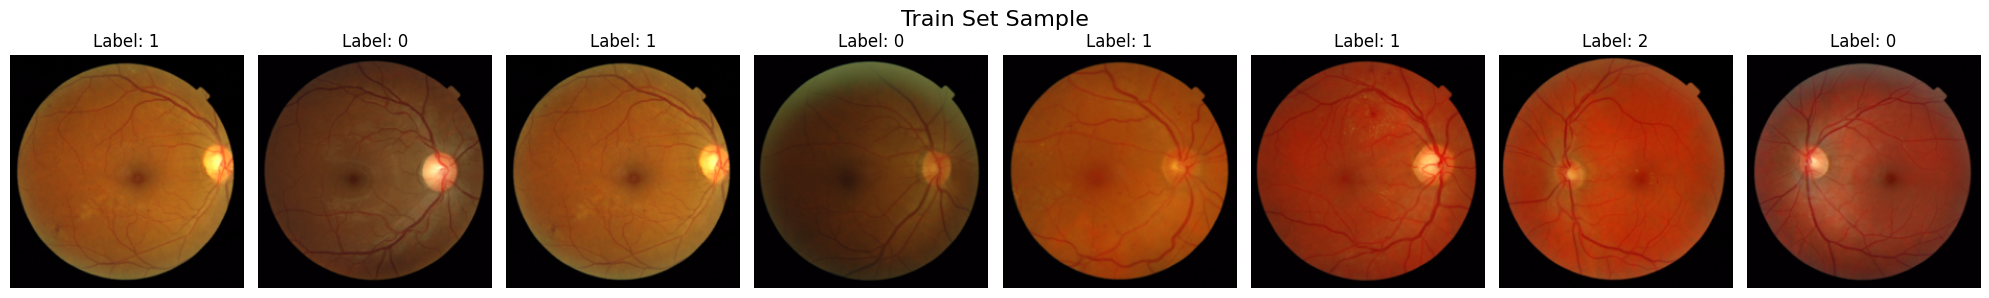

In [19]:
def plot_batch(loader, title="Batch from DataLoader", max_images=8):
    """
    Displays a batch of images from a DataLoader.

    Parameters:
    - loader: PyTorch DataLoader
    - title: Title for the plot
    - max_images: Maximum number of images to show (default: 8)
    """
    images, labels = next(iter(loader))
    num_images = min(len(images), max_images)

    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2.5, 3))
    fig.suptitle(title, fontsize=16)

    for idx in range(num_images):
        ax = axs[idx] if num_images > 1 else axs

        img = images[idx]
        label = labels[idx]


        # Handle grayscale (1 channel) and RGB (3 channels)
        if img.shape[0] == 1:
            ax.imshow(img[0], cmap='gray')
        else:
            ax.imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

        ax.set_title(f'Label: {label.item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Visualize Batches from All Datasets

plot_batch(train_loader, title="Train Set Sample")
#plot_batch(val_loader, title="Validation Set Sample")
#plot_batch(test_loader, title="Test Set Sample")


## 4. Model Definitions

### Define models and load pretrained ones

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class SimpleCNNv2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNNv2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def get_pretrained_model(name, num_classes, pretrained=True):
    if name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Model not supported.")
    return model


### Define models to train

In [21]:
# Define model dictionary

model_dict = {
    "SimpleCNN (no pretraining)": lambda: SimpleCNN(num_classes).to("cuda"),
    "SimpleCNNv2 (no pretraining)": lambda: SimpleCNNv2(num_classes).to("cuda"),
    "ResNet18 (pretrained)": lambda: get_pretrained_model("resnet18", num_classes, pretrained=True).to("cuda"),
    "ResNet18 (random init)": lambda: get_pretrained_model("resnet18", num_classes, pretrained=False).to("cuda"),
    "ResNet50 (pretrained)": lambda: get_pretrained_model("resnet50", num_classes, pretrained=True).to("cuda"),
    "ResNet50 (random init)": lambda: get_pretrained_model("resnet50", num_classes, pretrained=False).to("cuda"),
    "EfficientNetB0 (pretrained)": lambda: get_pretrained_model("efficientnet_b0", num_classes, pretrained=True).to("cuda"),
    "EfficientNetB0 (random init)": lambda: get_pretrained_model("efficientnet_b0", num_classes, pretrained=False).to("cuda"),
}


### Generate and print summaries

In [22]:
'''
for model_name, model_fn in model_dict.items():
    print(f"\n🔍 Summary for: {model_name}")
    try:
        model = model_fn()
        summary(model, input_size=(3, *image_size))
    except Exception as e:
        print(f"⚠️ Could not generate summary: {e}")
     '''


🔍 Summary for: SimpleCNN (no pretraining)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,248
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
           Flatten-7               [-1, 100352]               0
            Linear-8                   [-1, 16]       1,605,648
              ReLU-9                   [-1, 16]               0
          Dropout-10                   [-1, 16]               0
           Linear-11                    [-1, 3]              51
Total params: 1,615,843
Trainable params: 1,615,843
Non-trainable params: 0
------------------------------------------------

C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

## 5. Training models with early stopping

### Define Early stopping to avoid overfitting

In [23]:
class EarlyStopping:
    """
    Early stopping utility to stop training when validation loss doesn't improve.
    """
    def __init__(self, patience=5, min_delta=0.0, verbose=True, save_best_only=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.save_best_only = save_best_only
        self.best_model = None

    def __call__(self, val_loss: float, model: nn.Module):
        if val_loss < self.best_loss - self.min_delta:
            if self.verbose:
                print(f"Validation loss improved from {self.best_loss:.4f} to {val_loss:.4f}. Saving model...")
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


### Define training loop

In [24]:
def train_model(model, train_loader, val_loader, num_epochs, model_name, learning_rate=1e-4):
    """
    Train a model with early stopping and TensorBoard logging.

    Parameters:
    - model: the PyTorch model to train
    - train_loader, val_loader: DataLoaders
    - num_epochs: number of max training epochs
    - model_name: name for logging/saving
    - learning_rate: optimizer learning rate
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopping(patience=5, min_delta=1e-4, verbose=True)

    writer = SummaryWriter(log_dir=f'runs/{model_name}_{int(time.time())}')

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training loop
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        epoch_time = time.time() - start_time

        # Logging
        writer.add_scalars('Loss', {
            'train': avg_train_loss,
            'val': avg_val_loss
        }, epoch)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Time: {epoch_time:.2f}s")

        # Check early stopping
        early_stopper(avg_val_loss, model)
        if early_stopper.early_stop:
            print("🛑 Early stopping triggered.")
            break

    # Restore best model weights
    model.load_state_dict(early_stopper.best_model)
    torch.save(model.state_dict(), f"{model_name}.pth")
    writer.close()

    return model


### Train all models

In [25]:
# Define base log directory
log_root = "runs_all_models"
os.makedirs(log_root, exist_ok=True)

# Update model dictionary to avoid overwriting logs
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

for model_name, model_fn in model_dict.items():
    print(f"\n🚀 Training model: {model_name}")
    try:
        model = model_fn()  # Already moved to CUDA
        log_name = f"{model_name.replace(' ', '_')}_{timestamp}"
        trained_model = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=20,
            model_name=os.path.join(log_root, log_name),
            learning_rate=1e-4
        )
    except Exception as e:
        print(f"⚠️ Failed to train {model_name}: {e}")



🚀 Training model: SimpleCNN (no pretraining)
Epoch 1/20 - Train Loss: 1.1473, Val Loss: 1.2487, Time: 1.74s
Validation loss improved from inf to 1.2487. Saving model...
Epoch 2/20 - Train Loss: 1.0936, Val Loss: 1.1549, Time: 0.95s
Validation loss improved from 1.2487 to 1.1549. Saving model...
Epoch 3/20 - Train Loss: 1.0973, Val Loss: 1.1228, Time: 0.87s
Validation loss improved from 1.1549 to 1.1228. Saving model...
Epoch 4/20 - Train Loss: 1.0893, Val Loss: 1.1079, Time: 0.77s
Validation loss improved from 1.1228 to 1.1079. Saving model...
Epoch 5/20 - Train Loss: 1.0904, Val Loss: 1.1029, Time: 0.79s
Validation loss improved from 1.1079 to 1.1029. Saving model...
Epoch 6/20 - Train Loss: 1.1220, Val Loss: 1.1113, Time: 0.74s
No improvement. EarlyStopping counter: 1/5
Epoch 7/20 - Train Loss: 1.0988, Val Loss: 1.1206, Time: 0.84s
No improvement. EarlyStopping counter: 2/5
Epoch 8/20 - Train Loss: 1.1077, Val Loss: 1.1205, Time: 0.80s
No improvement. EarlyStopping counter: 3/5
Epoc

### Launch TensorBoard

In [1]:
# In a Jupyter notebook cell
%load_ext tensorboard
%tensorboard --logdir runs_all_models --port 6006


Reusing TensorBoard on port 6006 (pid 26888), started 13:09:36 ago. (Use '!kill 26888' to kill it.)

## 6. Evaluation on Test Set

In [29]:

def evaluate_model(model, model_name, dataloader, class_names=None):
    """
    Evaluate a trained model on a given dataloader.

    Args:
        model (nn.Module): Trained model to evaluate.
        model_name (str): Name for display in reports and plots.
        dataloader (DataLoader): DataLoader for evaluation (e.g. test set).
        class_names (list of str, optional): Class labels for report and confusion matrix.

    Returns:
        tuple: (confusion matrix, classification report as dict)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Print classification report
    print(f"\n📊 Classification Report for: {model_name}")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

    return cm, classification_report(y_true, y_pred, target_names=class_names, output_dict=True)


### Evaluate all trained models on the test set

IndentationError: expected an indented block after 'if' statement on line 7 (1617055685.py, line 10)


🔍 Loading and evaluating: EfficientNetB0 (pretrained) from EfficientNetB0_(pretrained)_20250603_053028.pth


C:\Users\andre\AppData\Local\Temp\ipykernel_24416\841016861.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de


📊 Classification Report for: EfficientNetB0 (pretrained)
              precision    recall  f1-score   support

     Grade 0       0.79      0.88      0.84        26
     Grade 1       0.00      0.00      0.00         4
     Grade 2       0.64      0.70      0.67        10

    accuracy                           0.75        40
   macro avg       0.48      0.53      0.50        40
weighted avg       0.67      0.75      0.71        40



C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

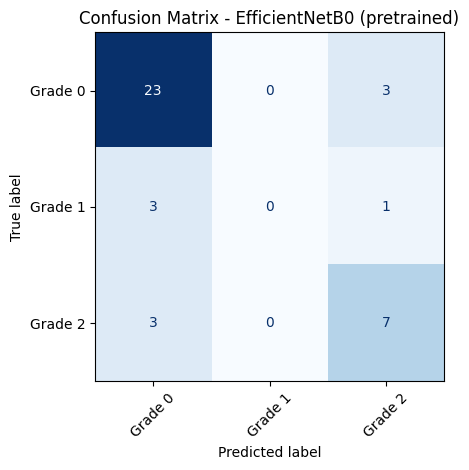


🔍 Loading and evaluating: EfficientNetB0 (pretrained) from EfficientNetB0_(pretrained)_20250603_124330.pth


C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


📊 Classification Report for: EfficientNetB0 (pretrained)
              precision    recall  f1-score   support

     Grade 0       0.79      0.88      0.84        26
     Grade 1       0.00      0.00      0.00         4
     Grade 2       0.64      0.70      0.67        10

    accuracy                           0.75        40
   macro avg       0.48      0.53      0.50        40
weighted avg       0.67      0.75      0.71        40



C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

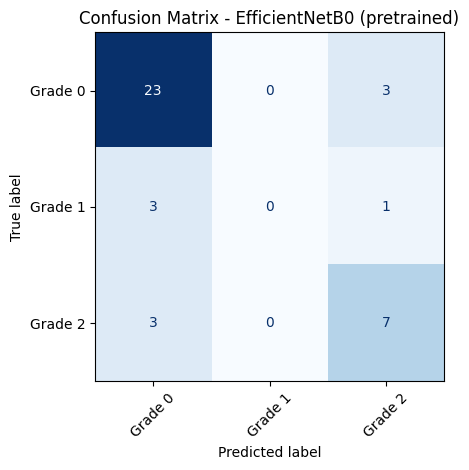


🔍 Loading and evaluating: EfficientNetB0 (pretrained) from EfficientNetB0_(random_init)_20250603_053028.pth


C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


📊 Classification Report for: EfficientNetB0 (pretrained)
              precision    recall  f1-score   support

     Grade 0       0.00      0.00      0.00        26
     Grade 1       0.10      1.00      0.18         4
     Grade 2       0.00      0.00      0.00        10

    accuracy                           0.10        40
   macro avg       0.03      0.33      0.06        40
weighted avg       0.01      0.10      0.02        40



C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

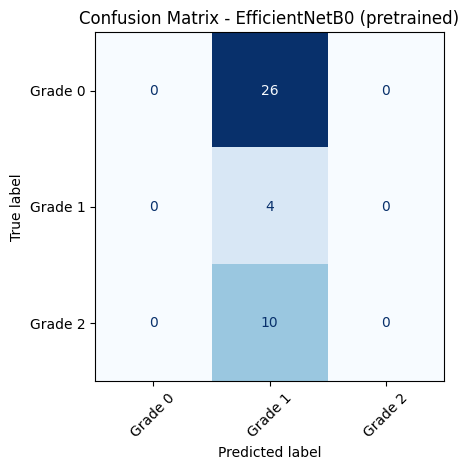


🔍 Loading and evaluating: EfficientNetB0 (pretrained) from EfficientNetB0_(random_init)_20250603_124330.pth


C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


📊 Classification Report for: EfficientNetB0 (pretrained)
              precision    recall  f1-score   support

     Grade 0       0.00      0.00      0.00        26
     Grade 1       0.10      1.00      0.18         4
     Grade 2       0.00      0.00      0.00        10

    accuracy                           0.10        40
   macro avg       0.03      0.33      0.06        40
weighted avg       0.01      0.10      0.02        40



C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

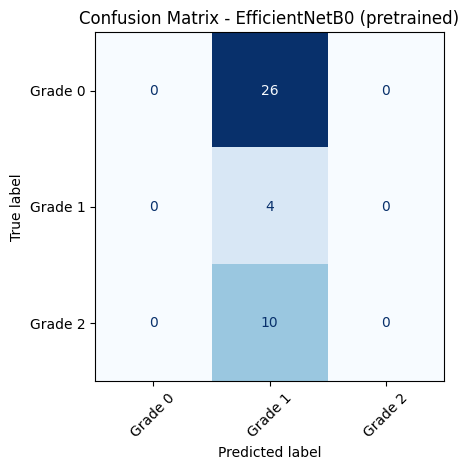


🔍 Loading and evaluating: ResNet18 (pretrained) from ResNet18_(pretrained)_20250603_051856.pth


C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


📊 Classification Report for: ResNet18 (pretrained)
              precision    recall  f1-score   support

     Grade 0       0.76      1.00      0.87        26
     Grade 1       0.00      0.00      0.00         4
     Grade 2       1.00      0.60      0.75        10

    accuracy                           0.80        40
   macro avg       0.59      0.53      0.54        40
weighted avg       0.75      0.80      0.75        40



C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

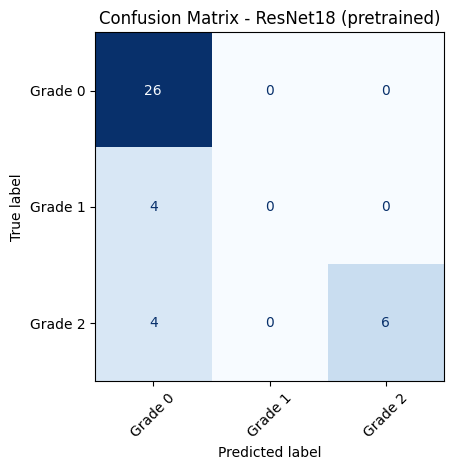


🔍 Loading and evaluating: ResNet18 (pretrained) from ResNet18_(pretrained)_20250603_053028.pth


C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


📊 Classification Report for: ResNet18 (pretrained)
              precision    recall  f1-score   support

     Grade 0       0.74      1.00      0.85        26
     Grade 1       0.00      0.00      0.00         4
     Grade 2       1.00      0.40      0.57        10

    accuracy                           0.75        40
   macro avg       0.58      0.47      0.47        40
weighted avg       0.73      0.75      0.70        40



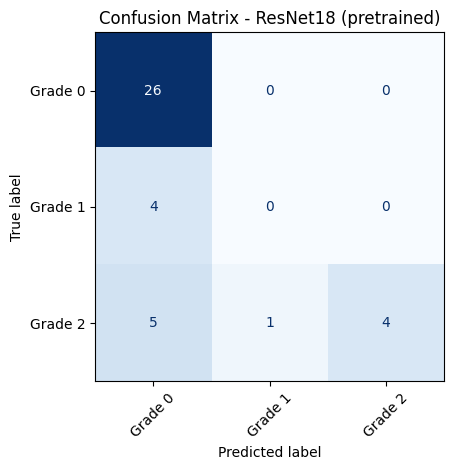


🔍 Loading and evaluating: ResNet18 (pretrained) from ResNet18_(pretrained)_20250603_124330.pth


C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\andre\AppData\Local\Temp\ipykernel_24416\841016861.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:/


📊 Classification Report for: ResNet18 (pretrained)
              precision    recall  f1-score   support

     Grade 0       0.74      1.00      0.85        26
     Grade 1       0.00      0.00      0.00         4
     Grade 2       1.00      0.40      0.57        10

    accuracy                           0.75        40
   macro avg       0.58      0.47      0.47        40
weighted avg       0.73      0.75      0.70        40



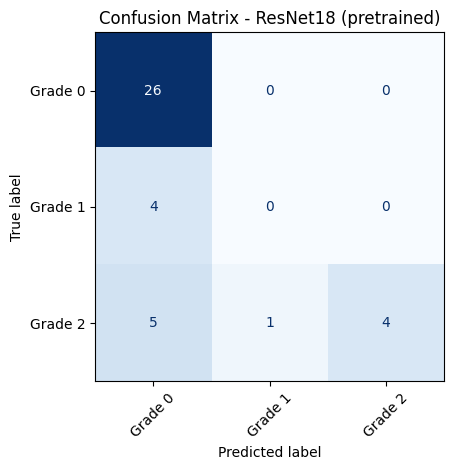


🔍 Loading and evaluating: ResNet18 (pretrained) from ResNet18_(random_init)_20250603_051856.pth


C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\andre\anaconda3\envs\anemone_tracking\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\andre\AppData\Local\Temp\ipykernel_24416\841016861.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:/

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [28]:

evaluation_results = {}

# Scan all .pth files in log_root
for file in os.listdir(log_root):
    if not file.endswith(".pth"):
        continue

    model_path = os.path.join(log_root, file)

    # Extract model name from filename to match keys in model_dict
    match = re.match(r"(.+?)(_\(|\()", file)  # Match until the first parenthesis
    if match:
        model_key = match.group(1).strip()
    else:
        model_key = file.replace(".pth", "").strip()

    # Find matching model in dictionary
    matching_keys = [key for key in model_dict.keys() if key.startswith(model_key)]
    if not matching_keys:
        print(f"⚠️ No matching model found in model_dict for: {model_key}")
        continue

    model_name = matching_keys[0]
    print(f"\n🔍 Loading and evaluating: {model_name} from {file}")

    # Load model
    model = model_dict[model_name]()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

    # Evaluate model
    cm, report = evaluate_model(model, model_name, test_loader, class_names=class_names)
    evaluation_results[model_name] = {
        "confusion_matrix": cm,
        "report": report
    }


## 7. Class Activation Maps (CAMs)

### Define fucntion to create CAMs

In [ ]:
def generate_cams(model, dataloader, target_layer='layer4', num_samples=10, class_names=None):
    """
    Generate and visualize CAMs (Class Activation Maps) for a given model and data loader.

    Args:
        model (nn.Module): Trained CNN model with a `.fc` classifier layer.
        dataloader (DataLoader): DataLoader for test or validation data.
        target_layer (str): Name of the layer to extract feature maps from (e.g. 'layer4' for ResNet).
        num_samples (int): Number of sample CAMs to display.
        class_names (list, optional): List of class names for labels. If None, class indices are shown.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # 🔍 Feature extractor: returns activations from the desired layer
    feature_extractor = create_feature_extractor(model, return_nodes={target_layer: "features"})

    # ⚖️ Get the final FC layer weights
    try:
        softmax_weights = model.fc.weight.detach()
    except AttributeError:
        raise ValueError("Model must have an attribute 'fc' with weight for CAM computation.")

    count = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            # Get feature maps and predictions
            features = feature_extractor(images)["features"]
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

        batch_size = images.size(0)

        for i in range(batch_size):
            if count >= num_samples:
                return

            # 🧠 Feature map → Class Activation Map
            feature_map = features[i]  # [C, H, W]
            pred_class = preds[i].item()
            label_class = labels[i].item()

            cam = torch.matmul(softmax_weights[pred_class], feature_map.view(feature_map.shape[0], -1))
            cam = cam.view(feature_map.shape[1], feature_map.shape[2]).cpu().numpy()
            cam = cv2.resize(cam, (images.shape[3], images.shape[2]))
            cam = (cam - cam.min()) / (cam.max() - cam.min())
            cam = np.uint8(255 * cam)
            heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

            # 🖼️ De-normalize and prepare original image
            img_np = images[i].detach().cpu().numpy().transpose(1, 2, 0)
            #img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_np = np.clip(img_np, 0, 1)
            img_np = np.uint8(255 * img_np)

            # 🎨 Overlay CAM on original image
            overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

            # 🧾 Titles
            pred_label = class_names[pred_class] if class_names else f"Class {pred_class}"
            true_label = class_names[label_class] if class_names else f"Class {label_class}"

            plt.figure(figsize=(4, 4))
            plt.imshow(overlay[..., ::-1])  # Convert BGR to RGB
            plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            count += 1

### Loop over all models

In [ ]:
# Loop over all trained models
for model_name, model in all_models.items():
    print(f"\n🔍 Generating CAMs for: {model_name}")

    # Load best weights
    try:
        model.load_state_dict(torch.load(f"{model_name}.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu'))
    except Exception as e:
        print(f"⚠️ Could not load weights for {model_name}: {e}")
        continue

    # Determine appropriate target layer
    if 'resnet' in model_name:
        target_layer = 'layer4'
    elif 'efficientnet' in model_name:
        target_layer = 'features.7'
    else:  # For custom CNNs
        target_layer = 'features.3'

    # Generate CAMs
    generate_cams(model, test_loader, model_name, target_layer=target_layer, num_samples=5)